# bag of holding (aka. making neural networks smaller)

## setup

In [346]:
import torch as t
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import wandb
from tqdm import tqdm
from datetime import datetime
import triton
import triton.language as tl

device = 'cuda' if t.cuda.is_available() else 'cpu'

In [347]:
batch_size = 640

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [348]:
def imshow(img):
    if img.shape[0] == 1: img = img.permute(1, 2, 0)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

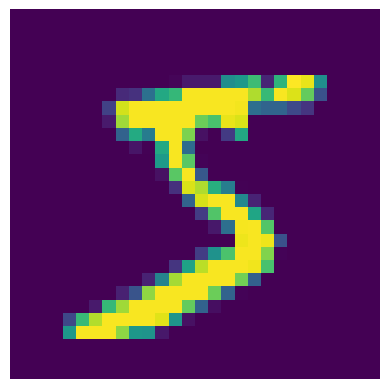

In [349]:
imshow(train_dataset[0][0])

In [436]:
class Mnist(nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(1024, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 10),
            # nn.Linear(784, 32),
            # nn.LeakyReLU(),
            # nn.Linear(32, 32),
            # nn.LeakyReLU(),
            # nn.Linear(32, 10),
        )

    def forward(self, x):
        # pad x to [..., 32, 32] because tritron's tl.dot makes life hard if it doesn't like the shape >_<'
        x = nn.functional.pad(x, (2, 2, 2, 2))
        return self.mlp(x.flatten(start_dim=-3))

In [437]:
@t.no_grad()
def eval(model, dataloader=test_loader):
    model.eval()
    loss, accuracy, count = 0, 0, 0
    for x, y in dataloader:
        logits = model(x.to(device))
        loss += F.cross_entropy(logits, y.to(device)).item()
        accuracy += (logits.argmax(1) == y.to(device)).sum().item()
        count += len(x)
    model.train()
    return loss / count, accuracy / count

def eval_dict(model, dataloader=test_loader, name='test'):
    loss, accuracy = eval(model, dataloader=dataloader)
    return {f'{name}_loss': loss, f'{name}_accuracy': accuracy}

# eval_dict(mnist)

In [438]:
def train(model, opt, dataloader=train_loader, wnb=True, epochs=1000):
    model.train()
    if wnb: wandb.init()
    for epoch in tqdm(range(epochs)):
        for x, y in dataloader:
            logits = model(x.to(device))
            loss = F.cross_entropy(logits, y.to(device))
            opt.zero_grad()
            loss.backward()
            opt.step()
        if epoch % 10 == 0 or epoch == epochs - 1:
            if wnb: wandb.log({'epoch': epoch} | eval_dict(model) | eval_dict(model, dataloader=train_loader, name='train'))
    if wnb: wandb.finish()

In [439]:
mnist = Mnist().to(device)
opt = optim.AdamW(mnist.parameters(), lr=3e-4)
train(mnist, opt, epochs=10)

100%|██████████| 10/10 [00:53<00:00,  5.31s/it]
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁█
test_accuracy,▁█
test_loss,█▁
train_accuracy,▁█
train_loss,█▁
epoch,9
test_accuracy,0.9468
test_loss,0.0003
train_accuracy,0.94897
train_loss,0.00028


In [440]:
t.save(mnist.state_dict(), f'weights/mnist-1024-128-64-10_{datetime.now().strftime("%Y-%m-%d_%Hh%M")}.pt')

## quantization

In [350]:
def quantize(weights, bits=8):
    ''' using the min-max strategy, this is vulnerable to outliers '''
    maxi = weights.max()
    mini = weights.min()
    qmaxi = 2 ** bits - 1
    scale = (maxi - mini) / qmaxi
    zero = int(t.round(-mini / scale))
    quantized_weights = t.clamp(t.round(weights / scale) + zero, 0, qmaxi)
    return quantized_weights, scale, zero

def unquantize(quantized_weights, scale, zero):
    return (quantized_weights - zero) * scale

In [355]:
def test_bounds(weights, bits=8):
    qw, _, _ = quantize(weights, bits=bits)
    assert qw.min() == 0
    assert qw.max() == 2**bits - 1

def test_round_trip(weights, bits=8, threshold=0.02):
    ''' this is flaky at best '''
    qw, scale, zero = quantize(weights, bits=bits)
    w = unquantize(qw, scale, zero)
    assert weights.allclose(w, atol=threshold), f'{(weights - w).abs().max()=}'

def test_more_bits_do_better(weights):
    ''' flaky too '''
    def encode_decode_max_abs_error(bits):
        qw, scale, zero = quantize(weights, bits=bits)
        w = unquantize(qw, scale, zero)
        return (weights - w).abs().max()
    error1 = encode_decode_max_abs_error(bits=4)
    error2 = encode_decode_max_abs_error(bits=8)
    error3 = encode_decode_max_abs_error(bits=16)
    assert error1 > error2 > error3, f'{error1=}, {error2=}, {error3=}'

for _ in range(100):
    xs = t.randn(100, 100)
    test_bounds(xs)
    test_round_trip(xs)
    test_more_bits_do_better(xs)

In [444]:
def quantization_stats(weights):
    qw, scale, zero = quantize(weights, bits=8)
    w = unquantize(qw, scale, zero)
    print(f'mean: {weights.mean()} {w.mean()}')
    print(f'max: {weights.max()} {w.max()}')
    print(f'min: {weights.min()} {w.min()}')
    print(f'atol: {(weights - w).abs().max()}')
    print(f'mse: {(weights - w).pow(2).mean()}')

xs = t.rand(10000)
quantization_stats(xs)

mean: 0.49788638949394226 0.4978831112384796
max: 0.999998152256012 0.9999329447746277
min: 6.520748138427734e-05 0.0
atol: 0.0019606351852416992
mse: 1.2737317547362181e-06


In [452]:
class QuantizedLinear(nn.Module):
    def __init__(self, linear):
        super().__init__()
        w, scale, zero = quantize(linear.weight.T)
        self.w = w.to(t.int8)
        self.register_buffer('w_matrix', self.w)
        self.w_scale = scale
        self.w_zero = zero
        self.bias = linear.bias # keep bias unquantized

    def forward(self, x):
        xq, x_scale, x_zero = quantize(x)
        xq = xq.to(t.int8)
        yq = matmul_i8i32(xq, self.w) # TODO: move definition above
        # yq = xq @ self.w
        y_scale = self.w_scale * x_scale
        y_zero = (self.w_zero + x_zero) / 2 # crappy approximation
        y = unquantize(yq, y_scale, y_zero)
        y = y + self.bias
        return y

In [453]:
def quantize_module(module):
    for name, node in module.named_children():
        if isinstance(node, nn.Linear):
            setattr(module, name, QuantizedLinear(node))
        else:
            quantize_module(node)

In [460]:
mnist = Mnist()
mnist.load_state_dict(t.load('weights/mnist-1024-128-64-10_2024-08-12_00h35.pt'))
mnist = mnist.to(device)
mnist.eval()
    
quantize_module(mnist)

In [455]:
mnist(test_loader.__iter__().__next__()[0].to(device))

tensor([[ 0.0073, -0.8909,  0.7959,  ...,  0.3277,  0.2032, -0.0178],
        [-0.6762, -0.1784, -0.1453,  ..., -0.1924,  0.3396, -0.1464],
        [-0.1886,  0.1256, -0.3160,  ...,  0.3358, -0.3032,  0.3776],
        ...,
        [ 0.2625, -1.2878,  0.8689,  ...,  0.0949, -0.5549,  0.1545],
        [ 1.2246,  0.1916, -1.1533,  ..., -0.3169, -0.3568, -0.9182],
        [-1.0592, -0.1841, -0.3325,  ...,  0.5067, -0.2770,  0.2965]],
       device='cuda:0', grad_fn=<AddBackward0>)

In [461]:
eval_dict(mnist.to(device))

{'test_loss': 0.0038383201837539674, 'test_accuracy': 0.1262}

## triton

In [426]:
# __heavily__ inspired by https://triton-lang.org/main/getting-started/tutorials/03-matrix-multiplication.html

@triton.jit
def matmul_kernel(
        # Pointers to matrices
        a_ptr, b_ptr, c_ptr,
        # Matrix dimensions
        M, N, K,
        # The stride variables represent how much to increase the ptr by when moving by 1
        # element in a particular dimension. E.g. `stride_am` is how much to increase `a_ptr`
        # by to get the element one row down (A has M rows).
        stride_am, stride_ak,
        stride_bk, stride_bn,
        stride_cm, stride_cn,
        # Meta-parameters
        BLOCK_SIZE_M: tl.constexpr,
        BLOCK_SIZE_N: tl.constexpr,
        BLOCK_SIZE_K: tl.constexpr,
        GROUP_SIZE_M: tl.constexpr,
):
    ''' Kernel for computing the matmul C = A x B.
    A has shape (M, K), B has shape (K, N) and C has shape (M, N)
    '''
    # -----------------------------------------------------------
    # Map program ids `pid` to the block of C it should compute.
    # This is done in a grouped ordering to promote L2 data reuse.
    # See above `L2 Cache Optimizations` section for details.
    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    # ----------------------------------------------------------
    # Create pointers for the first blocks of A and B.
    # We will advance this pointer as we move in the K direction
    # and accumulate
    # `a_ptrs` is a block of [BLOCK_SIZE_M, BLOCK_SIZE_K] pointers
    # `b_ptrs` is a block of [BLOCK_SIZE_K, BLOCK_SIZE_N] pointers
    # See above `Pointer Arithmetic` section for details
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_bn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)

    # -----------------------------------------------------------
    # Iterate to compute a block of the C matrix.
    # We accumulate into a `[BLOCK_SIZE_M, BLOCK_SIZE_N]` block
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.int32)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        # Load the next block of A and B, generate a mask by checking the K dimension.
        # If it is out of bounds, set it to 0.
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)
        b = tl.load(b_ptrs, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K, other=0.0)
        # We accumulate along the K dimension.
        accumulator = tl.dot(a, b, accumulator)
        # Advance the ptrs to the next K block.
        a_ptrs += BLOCK_SIZE_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * stride_bk
    c = accumulator.to(tl.int32)

    # -----------------------------------------------------------
    # Write back the block of the output matrix C with masks.
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, c, mask=c_mask)

def matmul_i8i32(a, b):
    ''' matmul for int8 with int32 accumulators '''
    assert a.shape[1] == b.shape[0], 'incompatible dimensions'
    assert a.is_contiguous(), 'matrix A must be contiguous'
    M, K = a.shape
    K, N = b.shape
    c = t.empty((M, N), device=a.device, dtype=t.int32)
    # launch kernel where each block gets its own program.
    grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']), )
    matmul_kernel[grid](
        a, b, c,
        M, N, K,
        a.stride(0), a.stride(1),
        b.stride(0), b.stride(1),
        c.stride(0), c.stride(1),
        BLOCK_SIZE_M=32,
        BLOCK_SIZE_N=32,
        BLOCK_SIZE_K=32,
        GROUP_SIZE_M=8,
    )
    return c

a = t.randint(-128, 128, (512, 1024), device='cuda', dtype=t.int8)
b = t.randint(-128, 128, (1024, 2048), device='cuda', dtype=t.int8)
triton_output = matmul_i8i32(a, b)
torch_output = t.matmul(a.to(t.float32), b.to(t.float32))

print(f'atol: {t.max(t.abs(triton_output - torch_output))}')
print(f'diff > 1e-5: {t.sum(t.abs(triton_output - torch_output) > 1e-5)} / {triton_output.numel()}')
print(f'allclose: {triton_output.float().allclose(torch_output)}')

atol: 0.0
diff > 1e-5: 0 / 1048576
allclose: True


In [427]:
# sanity check that int8 and uint8 behave the same
# because torch does not support uint8 on GPU
a = t.randint(-128, 128, (512,), device='cuda', dtype=t.int8)
b = t.randint(-128, 128, (512,), device='cuda', dtype=t.int8)
signed_sum = a + b
unsigned_sum = a.to(t.uint8) + b.to(t.uint8)

assert signed_sum.to(t.uint8).allclose(unsigned_sum)
assert signed_sum.allclose(unsigned_sum.to(t.int8))